In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv("loan_approval_dataset.csv") 

In [3]:
df.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   loan_id                    4269 non-null   int64 
 1    no_of_dependents          4269 non-null   int64 
 2    education                 4269 non-null   object
 3    self_employed             4269 non-null   object
 4    income_annum              4269 non-null   int64 
 5    loan_amount               4269 non-null   int64 
 6    loan_term                 4269 non-null   int64 
 7    cibil_score               4269 non-null   int64 
 8    residential_assets_value  4269 non-null   int64 
 9    commercial_assets_value   4269 non-null   int64 
 10   luxury_assets_value       4269 non-null   int64 
 11   bank_asset_value          4269 non-null   int64 
 12   loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB


In [5]:
df.isnull().sum()

loan_id                      0
 no_of_dependents            0
 education                   0
 self_employed               0
 income_annum                0
 loan_amount                 0
 loan_term                   0
 cibil_score                 0
 residential_assets_value    0
 commercial_assets_value     0
 luxury_assets_value         0
 bank_asset_value            0
 loan_status                 0
dtype: int64

In [6]:
list(df.columns)

['loan_id',
 ' no_of_dependents',
 ' education',
 ' self_employed',
 ' income_annum',
 ' loan_amount',
 ' loan_term',
 ' cibil_score',
 ' residential_assets_value',
 ' commercial_assets_value',
 ' luxury_assets_value',
 ' bank_asset_value',
 ' loan_status']

## Exploratory Data Analysis

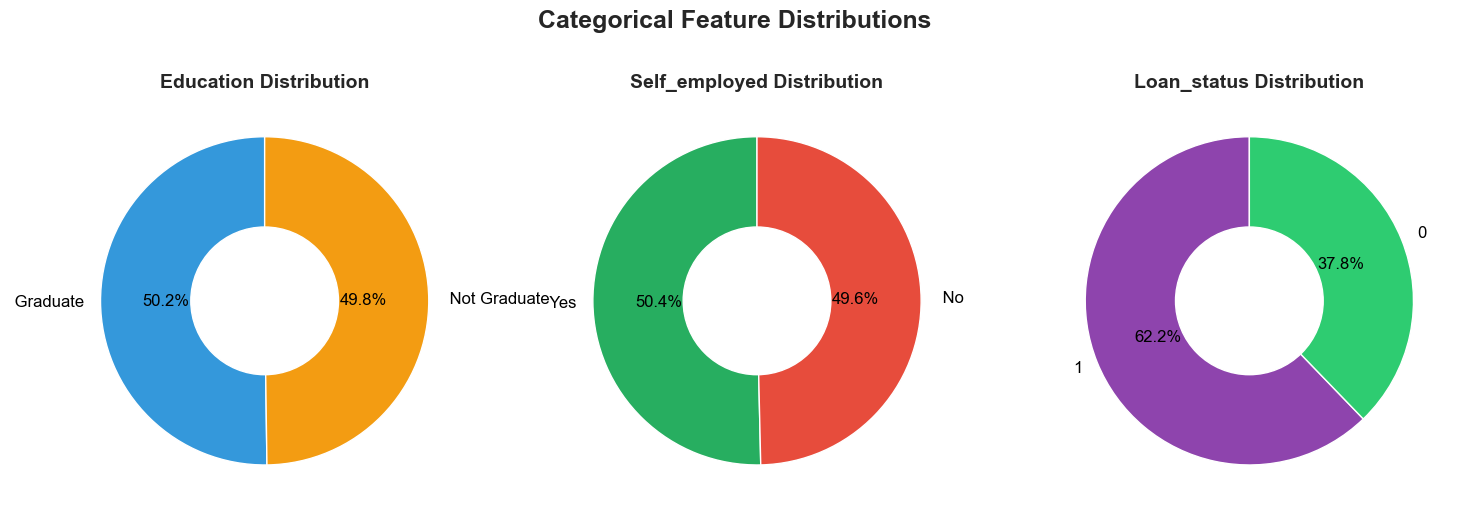

In [43]:
categorical_cols = ["education", "self_employed", "loan_status"]
colors_list = [["#3498db", "#f39c12"], ["#27ae60", "#e74c3c"], ["#8e44ad", "#2ecc71"]]

fig, axes = plt.subplots(1, 3, figsize=(18,6))

for i, col in enumerate(categorical_cols):
    values = df[col].value_counts()
    wedges, texts, autotexts = axes[i].pie(
        values, 
        labels=values.index, 
        autopct='%1.1f%%', 
        startangle=90, 
        colors=colors_list[i],
        textprops={'fontsize': 12, 'color':"black"}
    )
    centre_circle = plt.Circle((0,0),0.45,fc='white')
    axes[i].add_artist(centre_circle)
    axes[i].set_title(f"{col.capitalize()} Distribution", fontsize=14, fontweight="bold")

plt.suptitle("Categorical Feature Distributions", fontsize=18, fontweight="bold")
plt.show()

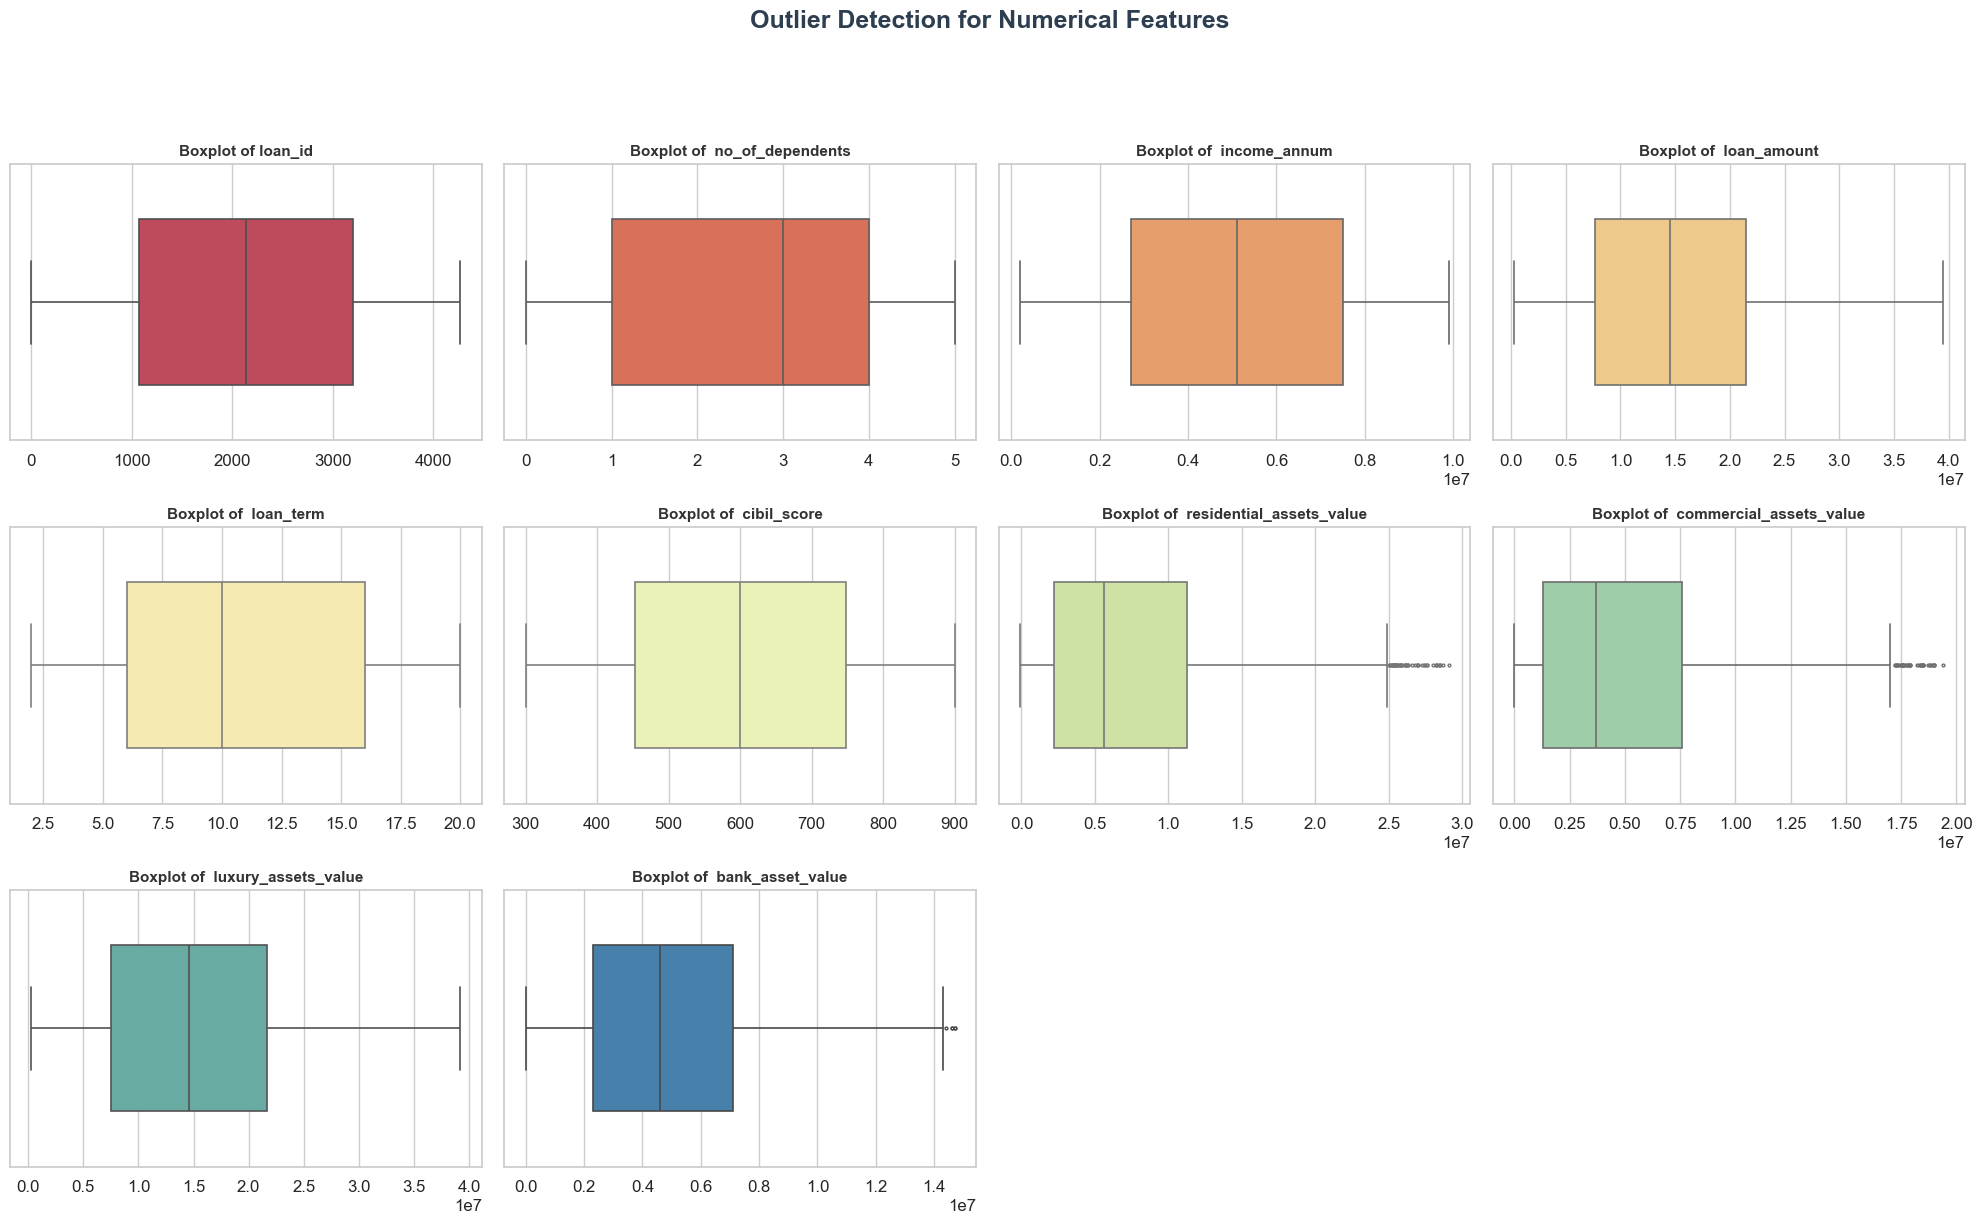

In [9]:
numerical = df.select_dtypes(include=['int64', 'float64']).columns
sns.set(style="whitegrid", palette="Spectral", font_scale=1.1)
palette = sns.color_palette("Spectral", len(numerical))
n_cols = 4
n_rows = int(np.ceil(len(numerical) / n_cols))
plt.figure(figsize=(20, n_rows * 4))
for i, col in enumerate(numerical, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(
        x=df[col],
        color=palette[i-1],
        width=0.6,
        fliersize=2,  
        linewidth=1.2
    )
    plt.title(f"Boxplot of {col}", fontsize=11, fontweight="bold", color="#333333")
    plt.xlabel("")  
plt.suptitle("Outlier Detection for Numerical Features", 
             fontsize=18, fontweight="bold", color="#2c3e50", y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.96])  
plt.show()

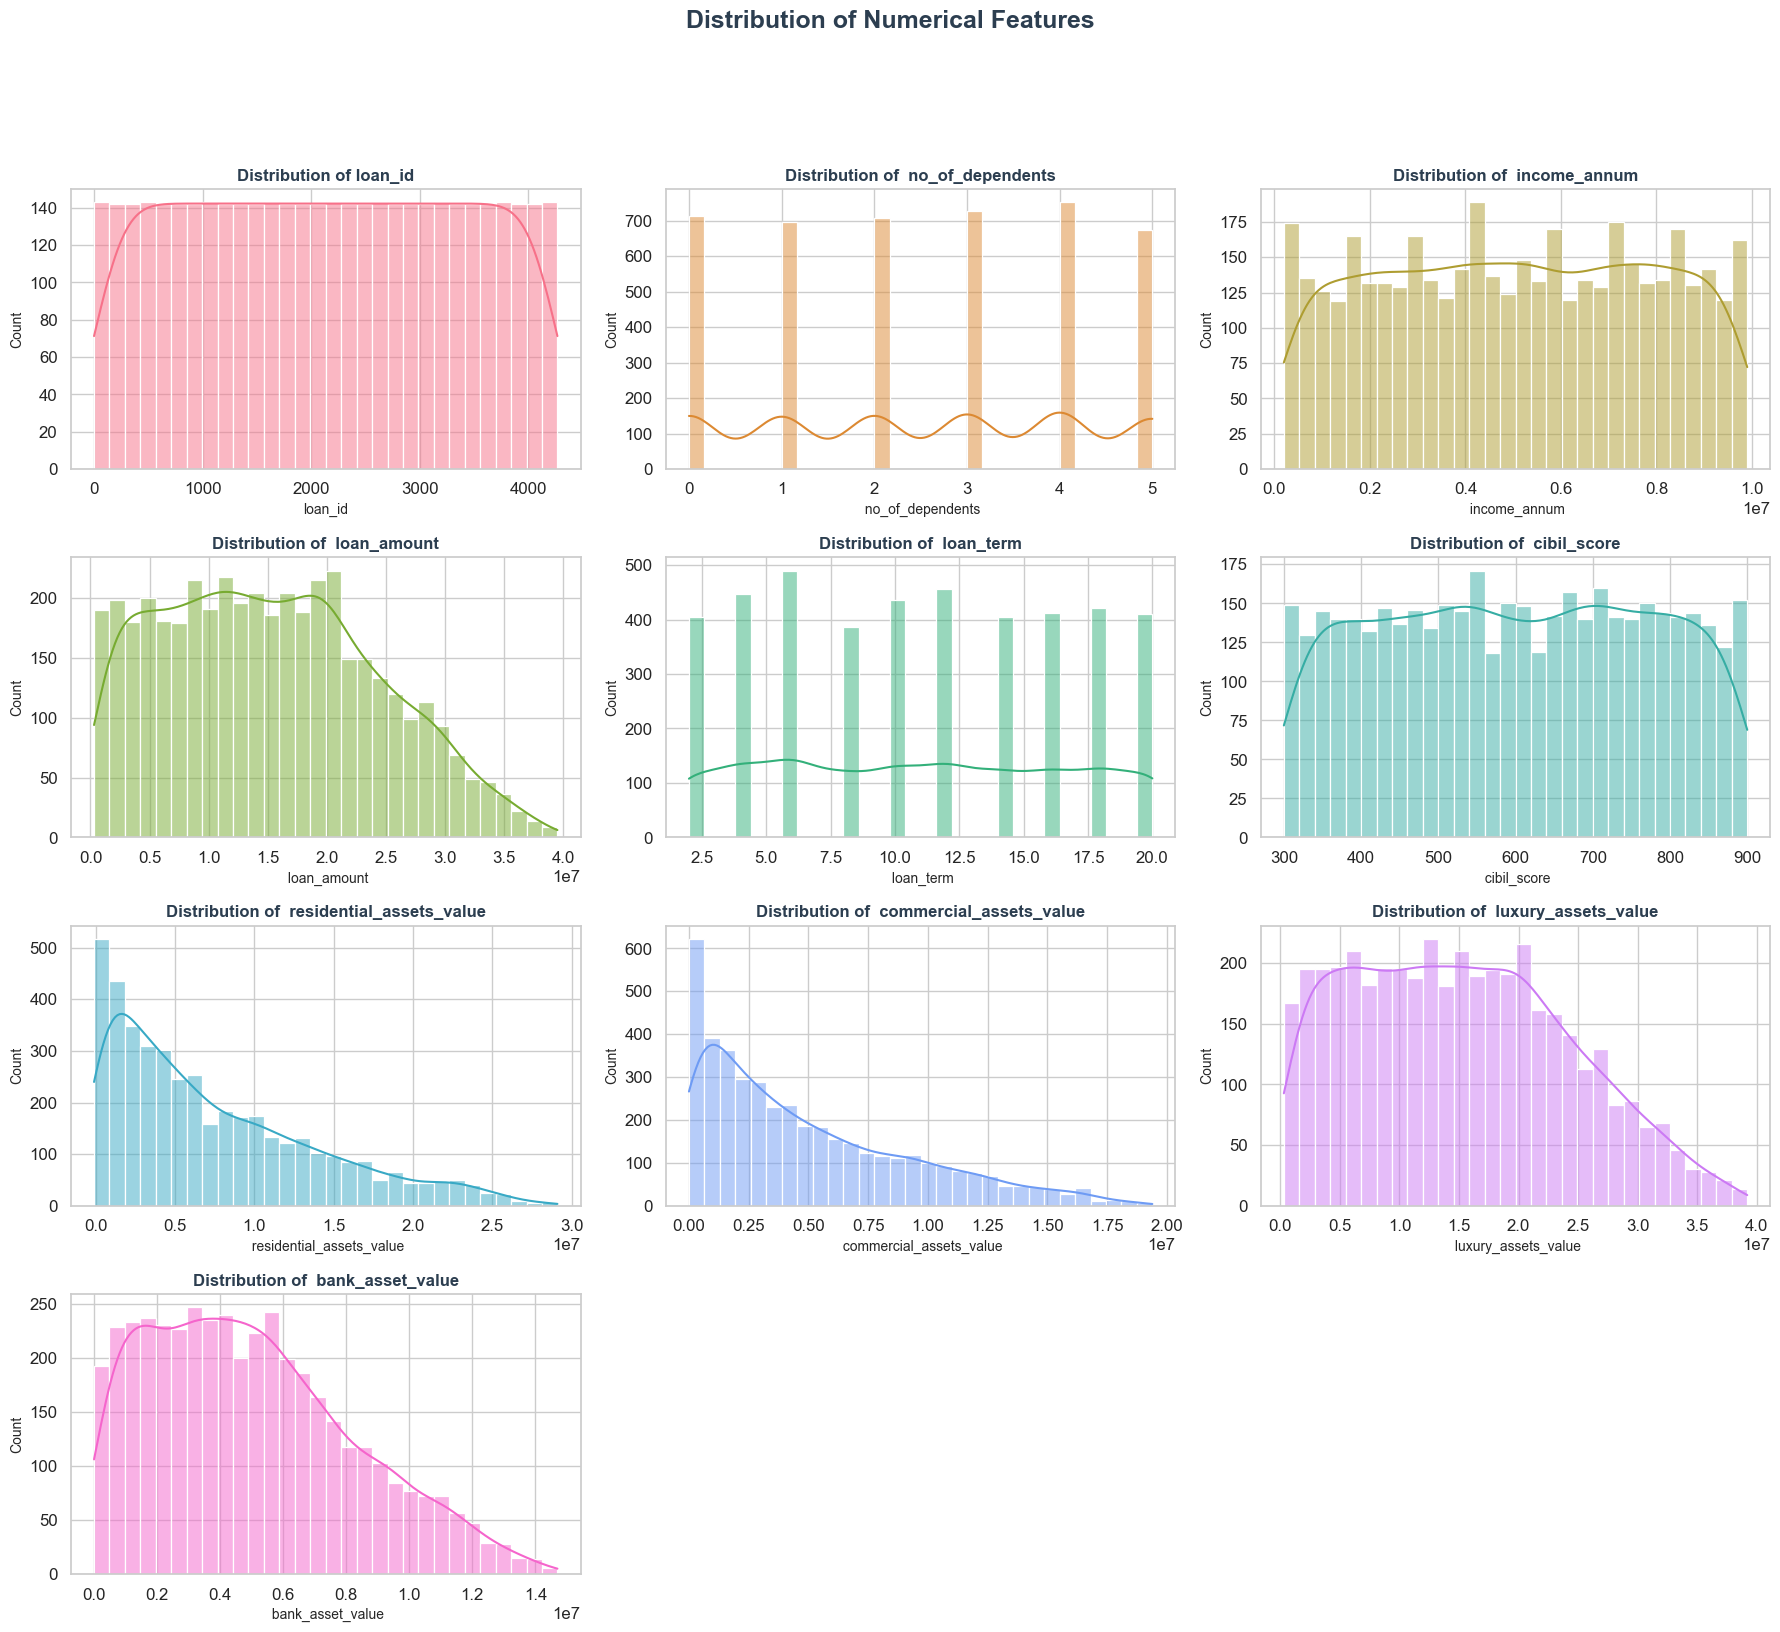

In [10]:
numerical = df.select_dtypes(include=['int64', 'float64']).columns
palette = sns.color_palette("husl", len(numerical))
n_cols = 3
n_rows = int(np.ceil(len(numerical) / n_cols))
plt.figure(figsize=(18, n_rows * 4))

for i, col in enumerate(numerical, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(
        df[col],
        kde=True,
        color=palette[i-1],
        bins=30
    )
    plt.title(f"Distribution of {col}", fontsize=12, fontweight="bold", color="#2c3e50")
    plt.xlabel(col, fontsize=10)
    plt.ylabel("Count", fontsize=10)

plt.suptitle("Distribution of Numerical Features", fontsize=18, fontweight="bold", color="#2c3e50", y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## Select features & target

In [11]:
df.columns = df.columns.str.strip().str.lower()

In [12]:
if "loan_id" in df.columns:
    df = df.drop("loan_id", axis=1)

In [13]:
df["loan_status"] = df["loan_status"].astype(str).str.strip().str.lower()
df["loan_status"] = df["loan_status"].map({"approved": 1, "rejected": 0})

In [14]:
print(df["loan_status"].value_counts())

loan_status
1    2656
0    1613
Name: count, dtype: int64


In [15]:
X = df.drop("loan_status", axis=1)
y = df["loan_status"]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

In [17]:
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

In [18]:
print("Numeric columns:", num_cols)

Numeric columns: ['no_of_dependents', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value']


In [19]:
print("Categorical columns:", cat_cols)

Categorical columns: ['education', 'self_employed']


# Preprocessing

In [20]:
num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

In [21]:
cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

In [22]:
preprocessor = ColumnTransformer([
    ("num", num_transformer, num_cols),
    ("cat", cat_transformer, cat_cols)
])

##  Class Balance Visualization

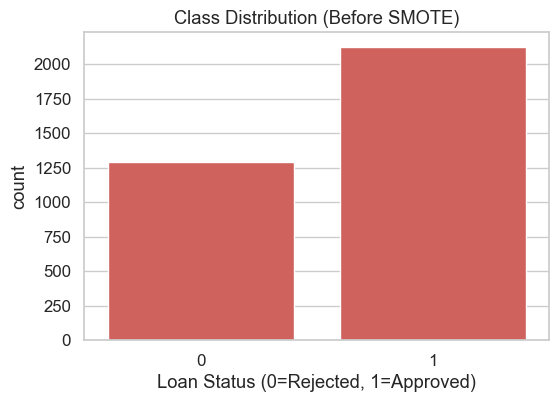

In [23]:
plt.figure(figsize=(6,4))
sns.countplot(x=y_train)
plt.title("Class Distribution (Before SMOTE)")
plt.xlabel("Loan Status (0=Rejected, 1=Approved)")
plt.show()

# Logistic Regression (Imbalanced Data)

In [24]:
log_reg_pipe = Pipeline([
    ("preproc", preprocessor),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
])
log_reg_pipe.fit(X_train, y_train)

,steps,"[('preproc', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [25]:
y_pred_lr = log_reg_pipe.predict(X_test)
y_prob_lr = log_reg_pipe.predict_proba(X_test)[:, 1]

print("\tLogistic Regression (Imbalanced Data) ")
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr, digits=4))

	Logistic Regression (Imbalanced Data) 

Classification Report:
               precision    recall  f1-score   support

           0     0.8772    0.9288    0.9023       323
           1     0.9551    0.9209    0.9377       531

    accuracy                         0.9239       854
   macro avg     0.9161    0.9248    0.9200       854
weighted avg     0.9256    0.9239    0.9243       854



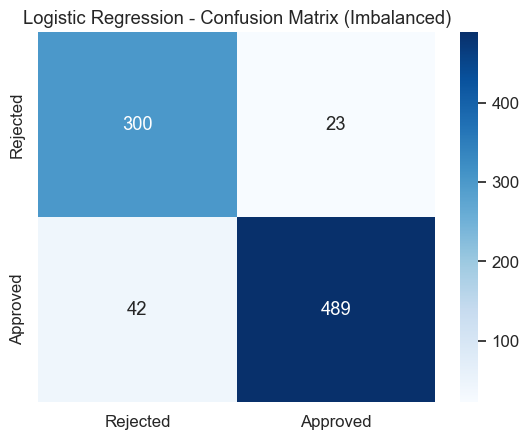

In [26]:
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Rejected","Approved"],
            yticklabels=["Rejected","Approved"])
plt.title("Logistic Regression - Confusion Matrix (Imbalanced)")
plt.show()

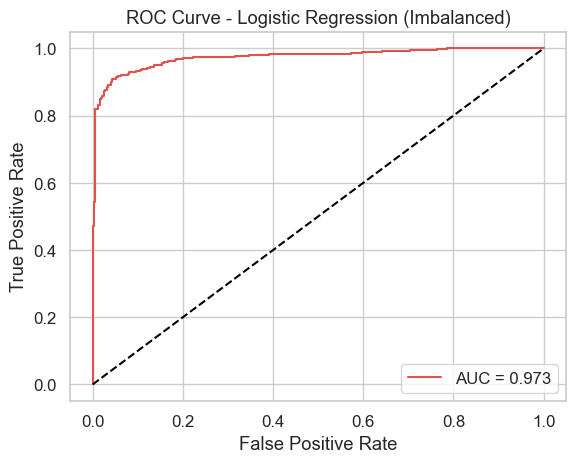

In [27]:
fpr, tpr, _ = roc_curve(y_test, y_prob_lr)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression (Imbalanced)")
plt.legend()
plt.show()

# Decision Tree (Imbalanced Data)

In [28]:
dt_pipe = Pipeline([
    ("preproc", preprocessor),
    ("clf", DecisionTreeClassifier(class_weight="balanced", random_state=42))
])
dt_pipe.fit(X_train, y_train)

,steps,"[('preproc', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [29]:
y_pred_dt = dt_pipe.predict(X_test)
y_prob_dt = dt_pipe.predict_proba(X_test)[:, 1]

print("\t Decision Tree (Imbalanced Data) ")
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt, digits=4))

	 Decision Tree (Imbalanced Data) 

Classification Report:
               precision    recall  f1-score   support

           0     0.9780    0.9628    0.9704       323
           1     0.9776    0.9868    0.9822       531

    accuracy                         0.9778       854
   macro avg     0.9778    0.9748    0.9763       854
weighted avg     0.9778    0.9778    0.9777       854



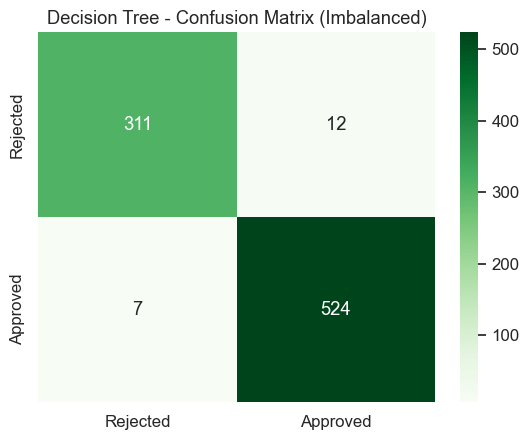

In [30]:
cm = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=["Rejected","Approved"],
            yticklabels=["Rejected","Approved"])
plt.title("Decision Tree - Confusion Matrix (Imbalanced)")
plt.show()

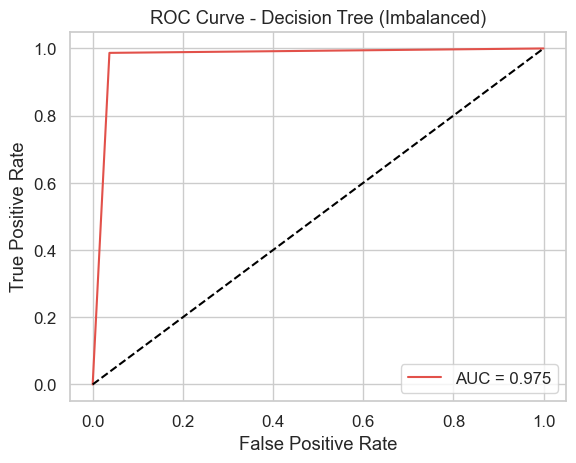

In [31]:
fpr, tpr, _ = roc_curve(y_test, y_prob_dt)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Decision Tree (Imbalanced)")
plt.legend()
plt.show()

## Apply SMOTE

In [32]:
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

In [33]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_prep, y_train)

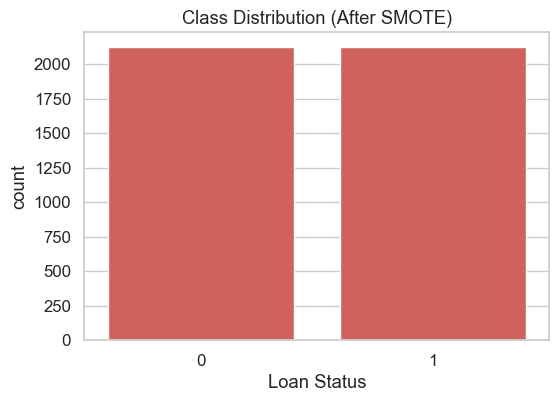

In [34]:
plt.figure(figsize=(6,4))
sns.countplot(x=y_train_res)
plt.title("Class Distribution (After SMOTE)")
plt.xlabel("Loan Status")
plt.show()

#  Logistic Regression (SMOTE)

In [35]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_res, y_train_res)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [36]:
y_pred_lr_sm = log_reg.predict(X_test_prep)
y_prob_lr_sm = log_reg.predict_proba(X_test_prep)[:, 1]

print("\t Logistic Regression (SMOTE) ")
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr_sm, digits=4))

	 Logistic Regression (SMOTE) 

Classification Report:
               precision    recall  f1-score   support

           0     0.8791    0.9226    0.9003       323
           1     0.9515    0.9228    0.9369       531

    accuracy                         0.9227       854
   macro avg     0.9153    0.9227    0.9186       854
weighted avg     0.9241    0.9227    0.9231       854



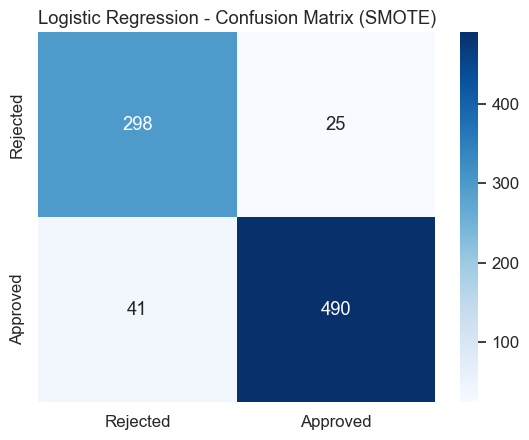

In [37]:
cm = confusion_matrix(y_test, y_pred_lr_sm)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Rejected","Approved"],
            yticklabels=["Rejected","Approved"])
plt.title("Logistic Regression - Confusion Matrix (SMOTE)")
plt.show()

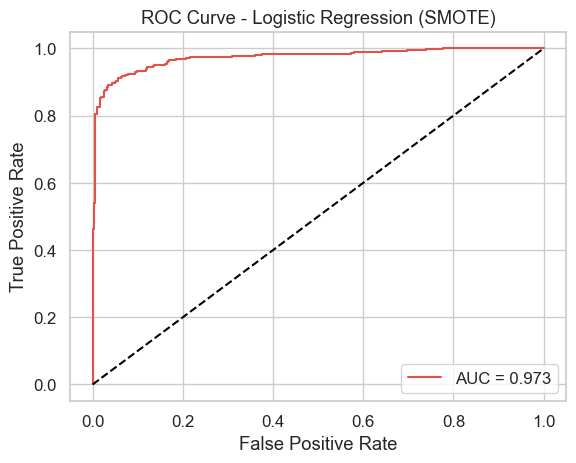

In [38]:
fpr, tpr, _ = roc_curve(y_test, y_prob_lr_sm)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression (SMOTE)")
plt.legend()
plt.show()

#  Decision Tree (SMOTE)

In [39]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_res, y_train_res)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [40]:
y_pred_dt_sm = dt.predict(X_test_prep)
y_prob_dt_sm = dt.predict_proba(X_test_prep)[:, 1]

print("\t Decision Tree (SMOTE) ")
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt_sm, digits=4))

	 Decision Tree (SMOTE) 

Classification Report:
               precision    recall  f1-score   support

           0     0.9749    0.9628    0.9688       323
           1     0.9776    0.9849    0.9812       531

    accuracy                         0.9766       854
   macro avg     0.9762    0.9739    0.9750       854
weighted avg     0.9766    0.9766    0.9766       854



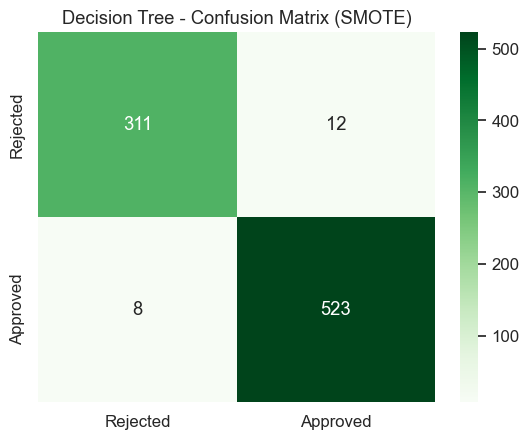

In [41]:
cm = confusion_matrix(y_test, y_pred_dt_sm)
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=["Rejected","Approved"],
            yticklabels=["Rejected","Approved"])
plt.title("Decision Tree - Confusion Matrix (SMOTE)")
plt.show()

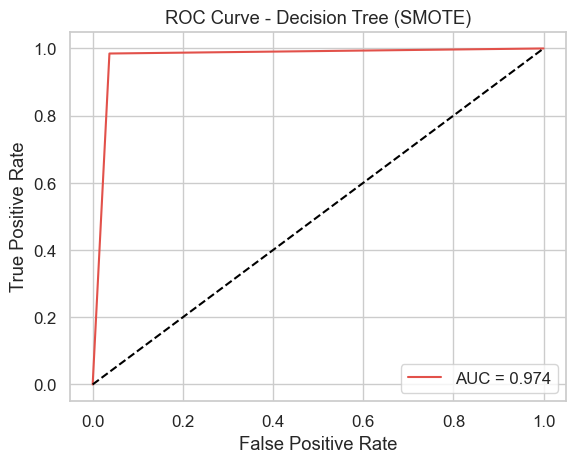

In [42]:
fpr, tpr, _ = roc_curve(y_test, y_prob_dt_sm)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Decision Tree (SMOTE)")
plt.legend()
plt.show()